## Simulation system

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

### Početni parametri

In [97]:
# Simulation parameters
num_points = 3 * 30 * 24 * 60  # 3 months of data, assuming 30 days per month
anomaly_chance = np.random.uniform(0.00005, 0.00012)  # [0.005-0.012]% chance of an anomaly
times = pd.date_range(start="2024-04-20", periods=num_points, freq='T')

# Anomaly counter
anomalies = 0

### Generiranje podataka

In [98]:
# Initialize sensors
accelerometer = np.zeros((num_points, 3), dtype=float)
gyroscope = np.zeros((num_points, 3), dtype=float)
magnetometer = np.zeros((num_points, 3), dtype=float)
temperature = np.full(num_points, 37.0, dtype=float)  # Ensure float type
pressure = np.full(num_points, 100.0, dtype=float)    # Ensure float type
light = np.full(num_points, 100.0, dtype=float)       # Ensure float type
behavior = np.full(num_points, "resting", dtype=object)


# Define behavior probabilities and transitions
curr_behavior = "resting"
behavior_duration = 0
time_since_last_change = 0
sleep_start_time = np.random.randint(18 * 60, 24 * 60)  # Sleep can start between 6pm and 12am
sleep_duration = np.random.randint(3 * 60, 4 * 60 + 1)  # Sleep duration between 3 and 4 hours in minutes

def daily_temperature_variation(hour, base_temp=20):
    # Simulate cooler temperatures at night and warmer during the day
    return base_temp + 10 * np.sin(np.pi * (hour - 6) / 12)

# Function to simulate daily light variation
def daily_light_variation(hour):
    # Light intensity peaks at noon and is zero at night
    return max(0, 1000 * np.sin(np.pi * (hour - 6) / 18))

# Function to simulate daily pressure variation
def daily_pressure_variation(hour, base_pressure=1013):
    # Slight fluctuation in pressure throughout the day
    return base_pressure + 5 * np.sin(np.pi * (hour - 6) / 12)

for i in range(1, num_points):
    current_minute = i % 1440  # Current minute in the day
    current_hour = current_minute // 60 # Current hour in the day

    temperature[i] = daily_temperature_variation(current_hour)
    light[i] = daily_light_variation(current_hour)
    pressure[i] = daily_pressure_variation(current_hour)

    # Check if it's time to sleep
    if sleep_start_time <= current_minute < sleep_start_time + sleep_duration:
        curr_behavior = "sleeping"
    else:
        if behavior_duration <= 0:
            change_probability = 0.05 + 0.001 * time_since_last_change
            if np.random.random() < change_probability:
                possible_behaviors = ["running", "walking", "resting"]
                if curr_behavior in possible_behaviors:
                    possible_behaviors.remove(curr_behavior)  # Remove current behavior from the list if it exists
                curr_behavior = np.random.choice(possible_behaviors)
                min_behavior_duration = {"running": 10, "walking": 20, "resting": 30}[curr_behavior]
                behavior_duration = np.random.randint(min_behavior_duration, min_behavior_duration + 20)
                time_since_last_change = 0
        else:
            behavior_duration -= 1
            time_since_last_change += 1


    # Sensor data generation based on behavior
    if curr_behavior == "running":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(5, 2, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(300, 50, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.1, 3)
        behavior[i] = "running"
    elif curr_behavior == "walking":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(1, 0.5, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(100, 20, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.05, 3)
        behavior[i] = "walking"
    elif curr_behavior == "resting":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(0, 0.1, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(0, 5, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.02, 3)
        behavior[i] = "resting"
    elif curr_behavior == "sleeping":
        accelerometer[i] = np.random.normal(0, 0.05, 3)
        gyroscope[i] = np.random.normal(0, 1, 3)
        magnetometer[i] = np.random.normal(0, 0.01, 3)
        behavior[i] = "sleeping"


### Anomalije

In [99]:
def introduce_anomalies(data, num_points):
    num_anomalies = random.randint(5, 15)  # Randomly choose between 5 and 15 anomalies
    minutes_per_anomaly = [random.randint(60, 2160) for _ in range(num_anomalies)]  # 1 hour to 1.5 days in minutes
    sensors = ['temperature', 'pressure', 'light', 'accelerometer', 'gyroscope', 'magnetometer']

    # Print the number of anomalies
    print(f"Number of anomalies: {num_anomalies}")
    print("--------------------")

    for anomaly_index in range(num_anomalies):
        start_time = random.randint(0, num_points - 1)
        duration = random.choice(minutes_per_anomaly)
        end_time = min(start_time + duration, num_points)
        num_sensors_affected = random.randint(1, 2)  # Randomly choose to affect 1 or 2 sensors
        affected_sensors = random.sample(sensors, num_sensors_affected)  # Randomly pick sensors

        # Print anomaly details
        print(f"Anomaly {anomaly_index + 1}:")
        print(f"  Start Time Index: {start_time}")
        print(f"  Duration: {duration} minutes")
        print(f"  Affected Sensors: {', '.join(affected_sensors)}")

        for sensor in affected_sensors:
            if sensor == 'temperature':
                data['temperature'][start_time:end_time] += np.random.normal(5, 2, end_time - start_time)
            elif sensor == 'pressure':
                data['pressure'][start_time:end_time] -= np.random.normal(20, 5, end_time - start_time)
            elif sensor == 'light':
                data['light'][start_time:end_time] = np.random.randint(0, 50, end_time - start_time)
            elif sensor == 'accelerometer':
                data['accelerometer'][start_time:end_time] += np.random.normal(10, 5, (end_time - start_time, 3))
            elif sensor == 'gyroscope':
                data['gyroscope'][start_time:end_time] += np.random.normal(500, 100, (end_time - start_time, 3))
            elif sensor == 'magnetometer':
                data['magnetometer'][start_time:end_time] += np.random.normal(1, 0.5, (end_time - start_time, 3))

        # Tag behavior as anomaly during the anomaly period
        data['behavior'][start_time:end_time] = 'anomaly'

    return data

# Create a dictionary of your data arrays for easier manipulation
sensor_data = {
    'temperature': temperature,
    'pressure': pressure,
    'light': light,
    'behavior': behavior,
    'accelerometer': accelerometer,
    'gyroscope': gyroscope,
    'magnetometer': magnetometer
}

# Introduce anomalies
sensor_data = introduce_anomalies(sensor_data, num_points)

# Update your arrays from the dictionary
temperature = sensor_data['temperature']
pressure = sensor_data['pressure']
light = sensor_data['light']
behavior = sensor_data['behavior']
accelerometer = sensor_data['accelerometer']
gyroscope = sensor_data['gyroscope']
magnetometer = sensor_data['magnetometer']

# Remove the first row of data from each sensor array and the behavior array
accelerometer = accelerometer[1:]
gyroscope = gyroscope[1:]
magnetometer = magnetometer[1:]
temperature = temperature[1:]
pressure = pressure[1:]
light = light[1:]
behavior = behavior[1:]
times = times[1:]

Number of anomalies: 13
--------------------
Anomaly 1:
  Start Time Index: 125
  Duration: 1015 minutes
  Affected Sensors: temperature, pressure
Anomaly 2:
  Start Time Index: 20472
  Duration: 825 minutes
  Affected Sensors: magnetometer
Anomaly 3:
  Start Time Index: 50936
  Duration: 409 minutes
  Affected Sensors: pressure, accelerometer
Anomaly 4:
  Start Time Index: 72394
  Duration: 1015 minutes
  Affected Sensors: light, magnetometer
Anomaly 5:
  Start Time Index: 40297
  Duration: 798 minutes
  Affected Sensors: pressure, temperature
Anomaly 6:
  Start Time Index: 75435
  Duration: 831 minutes
  Affected Sensors: accelerometer, light
Anomaly 7:
  Start Time Index: 85538
  Duration: 993 minutes
  Affected Sensors: magnetometer, pressure
Anomaly 8:
  Start Time Index: 44032
  Duration: 993 minutes
  Affected Sensors: magnetometer
Anomaly 9:
  Start Time Index: 129559
  Duration: 752 minutes
  Affected Sensors: accelerometer, magnetometer
Anomaly 10:
  Start Time Index: 37381
 

### Izrada DataFrame-a

In [100]:

# Create DataFrame
df = pd.DataFrame({
    'Accelerometer_X': accelerometer[:, 0],
    'Accelerometer_Y': accelerometer[:, 1],
    'Accelerometer_Z': accelerometer[:, 2],
    'Gyroscope_X': gyroscope[:, 0],
    'Gyroscope_Y': gyroscope[:, 1],
    'Gyroscope_Z': gyroscope[:, 2],
    'Magnetometer_X': magnetometer[:, 0],
    'Magnetometer_Y': magnetometer[:, 1],
    'Magnetometer_Z': magnetometer[:, 2],
    'Temperature': temperature,
    'Pressure': pressure,
    'Light': light,
    'Behavior': behavior
}, index=times)

### Prikazivanje podataka

       Accelerometer_X  Accelerometer_Y  Accelerometer_Z    Gyroscope_X  \
count    129599.000000    129599.000000    129599.000000  129599.000000   
mean        938.853073       939.944688       939.694318   64337.559725   
std         713.409061       714.823023       713.353745   47877.588260   
min          -3.001697        -5.343850        -1.558966     -85.501212   
25%         283.180610       284.576852       283.440022   20486.350571   
50%         890.971515       886.215444       893.644042   61708.680363   
75%        1498.008339      1508.060805      1507.912699  103060.571121   
max        3040.239100      3021.875272      2924.396000  193694.524709   

         Gyroscope_Y    Gyroscope_Z  Magnetometer_X  Magnetometer_Y  \
count  129599.000000  129599.000000   129599.000000   129599.000000   
mean    64241.608858   64330.980813        0.063808        0.193861   
std     47804.068357   47882.789750        1.422552        1.540536   
min      -107.567201    -149.042064     

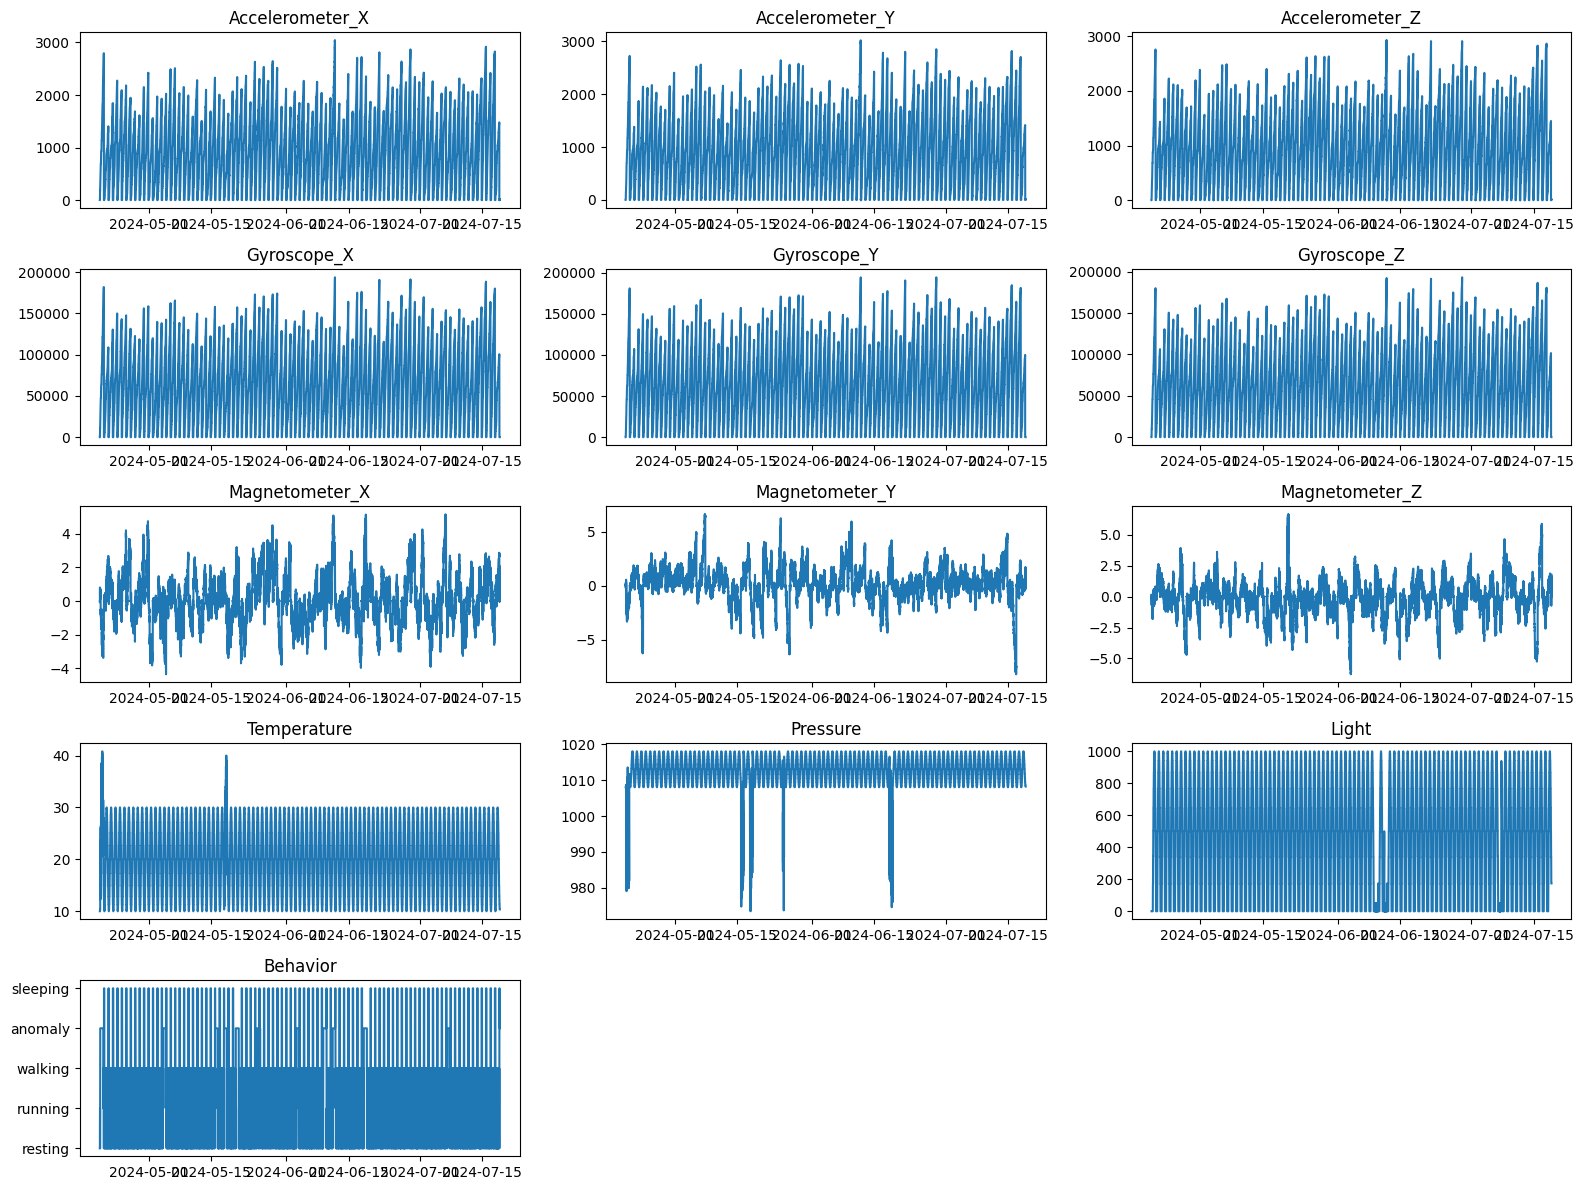

In [101]:
# Displaying statistical summary of the data
print(df.describe())

# Displaying the data
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns):
    plt.subplot(5, 3, i + 1)
    plt.plot(df.index, df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

### Spremanje podataka u CSV datoteku

In [102]:
# Sava data to CSV file
df.to_csv('sensor_data.csv')